# DP0701EN-Week5-PeerGraded Project - Report

In this week, you will continue working on your capstone project. Please remember by the end of this week, you will need to submit the following:

1. A full report consisting of all of the following components (15 marks):
* Introduction where you discuss the business problem and who would be interested in this project.
* Data where you describe the data that will be used to solve the problem and the source of the data.
* Methodology section which represents the main component of the report where you discuss and describe any exploratory data analysis that you did, any inferential statistical testing that you performed, if any, and what machine learnings were used and why.
* Results section where you discuss the results.
* Discussion section where you discuss any observations you noted and any recommendations you can make based on the results.
* Conclusion section where you conclude the report.

2. A link to your Notebook on your Github repository pushed showing your code. (15 marks)

3. Your choice of a presentation or blogpost. (10 marks)

## Topic: 

## The Battle of Neighborhoods - Where should I open a sushi restaurant in Toronto? - Part 2

### Introduction

For a city of enthusiastic eaters, it’s no surprise that food startups are emerging as one of Toronto’s most attractive areas for entrepreneurship.

Toronto is a city where people form long lines for a taste of new restaurants. With a half of the city’s population born outside of Canada, the downtown core and attached neighbourhoods easily offer anything from pho and jerk chicken to ballotines and samosas.

So Torontonians are always going to be interested in trying food from all over the world and Sushi is always among the Torontonians' favorite foods. In this report, I would like to explore the neighborhoods of the Toronto city and find out the potential best place to open a sushi restaurant.

### Data

The data containing geolocations of sushi restaurants and neighborhoods will be collected from FourSquare. The location dataframe scraped from the online webpage consists of columns: 
* “PostalCode”, 
* “Borough”, 
* “Neighborhood”, 
* “Latitude”, 
* “Longitude”. 

The nearby-venue dataframe from FourSquare  consists of columns: 
* “Neighborhood”, 
* “Neighborhood Latitude”, 
* “Neighborhood Longitude”, 
* “Venue”,
* “Venue Latitude”, 
* “Venue Longitude”,
* “Venue Category”. 

After counting by "Neighborhood", we will be able to list the  top 5 most common venues in each neighborhood and the location of already existing sushi restaurants. In the end,  we can carry out an unsupervised machine learning technique  to determine the area of influence of the existing sushi restaurants, and find the possible optimal locations for our sushi start up.

**Examples of Data-1**

|PostalCode|Borough|Neighborhood|Latitude|Longitude|
|----------|-------|------------|--------|---------|
|AAA|XXXXXXXX|XXXXXXX| 99.9999999|11.1111111|

**Examples of Data-2**

|Neighborhood|Neighborhood Latitude|Neighborhood Longitude|Venue|Venue Latitude|Venue Longitude|Venue Category|
|------------|---------------------|----------------------|-----|--------------|---------------|--------------|
|XXXXXXXX| 99.9999999|11.1111111|XXXXXXXXXXX|99.9999999|11.1111111|XXXXXXXX|

### Methodology

We will preprocess the data from FourSquare and get the dataframe we introduced in the part "Data" together with some visualization of the data. Then we use an unsupervised machine learning technique to find the solution, i.e potential  best neighborhood for our sushi start up.

**Step 0: get ready**

**import libraries**

In [1]:
#!conda install -c conda-forge folium=0.5.0 --yes
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

#Matplotlib and associated plotting modules
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

#import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes b
import folium # map rendering library
from folium import plugins

print('Libraries imported.')

Libraries imported.


**FourSquare ID and Credential**

In [2]:
CLIENT_ID = 'FDGPCM2RQRFB025MFXJVNTGPWASHXNOHERNUFARTZGK5IMFB' # your Foursquare ID
CLIENT_SECRET = 'JGNW3512LLQVHL1GDKTA2O5WUCKQV2DNW1I3FGCT1KQPUZ0T' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

**define functions to be used later**

In [3]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [4]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [5]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [6]:
def add_markers(df, maptoadd):
    for (j, row) in df.iterrows():
        label = folium.Popup(row["Name"], parse_html = True)
        folium.CircleMarker(
            [row["Latitude"], row["Longitude"]],
            radius = 5,
            popup = label,
            color = 'red',
            fill = True,
            fill_color = '#3186cc',
            fill_opacity = 0.7,
            parse_html = False).add_to(maptoadd)

**Step 1: Prepare the dataframe**

**Step 1.1: import data with neighborhood latitude and longitude**

In [7]:
df = pd.read_csv("Week3project.csv")
Toronto = df[df['Borough'].str.contains("Toronto")]
Toronto.reset_index(inplace = True)
Toronto.drop(['index', 'Unnamed: 0'],axis = 1, inplace = True)
Toronto.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572
1,M4P,Central Toronto,Davisville North,43.712751,-79.390197
2,M6K,West Toronto,"Brockton, Exhibition Place, Parkdale Village",43.636847,-79.428191
3,M5L,Downtown Toronto,"Commerce Court, Victoria Hotel",43.648198,-79.379817
4,M4V,Central Toronto,"Deer Park, Forest Hill SE, Rathnelly, South Hi...",43.686412,-79.400049


**Step 1.2: get coordinates** 

In [8]:
address = 'Toronto'
geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude,longitude))

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Using Nominatim with the default "geopy/1.21.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  


The geograpical coordinate of Toronto are 43.653963, -79.387207.


**Step 1.3: visualization of neighborhoods** 

In [9]:
map_trt = folium.Map(location=[latitude, longitude], zoom_start=11)

for lat, lng, label in zip(Toronto['Latitude'], Toronto['Longitude'], Toronto['Neighborhood']):
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [lat, lng],
        radius = 5,
        popup = label,
        color = 'blue',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.7,
        parse_html = False).add_to(map_trt)  
    
map_trt

**Step 1.4: get the top 500 venues that are in Toronto within a radius of 1000 meters**

In [10]:
LIMIT = 500 # limit of number of venues returned by Foursquare API

radius = 1000 # define radius

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)

In [11]:
results = requests.get(url).json()

**Step 1.5: get information of nearby venues**

In [12]:
venues = results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues = nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis = 1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Downtown Toronto,Neighborhood,43.653232,-79.385296
1,Japango,Sushi Restaurant,43.655268,-79.385165
2,Karine's,Breakfast Spot,43.653699,-79.390743
3,Manpuku まんぷく,Japanese Restaurant,43.653612,-79.390613
4,Nathan Phillips Square,Plaza,43.652270,-79.383516


In [13]:
venues_trt = getNearbyVenues(names = Toronto['Neighborhood'],
                                     latitudes = Toronto['Latitude'],
                                     longitudes = Toronto['Longitude'])

The Beaches West, India Bazaar
Davisville North
Brockton, Exhibition Place, Parkdale Village
Commerce Court, Victoria Hotel
Deer Park, Forest Hill SE, Rathnelly, South Hill, Summerhill West
Roselawn
Rosedale
The Danforth West, Riverdale
Chinatown, Grange Park, Kensington Market
Studio District
Harbord, University of Toronto
The Annex, North Midtown, Yorkville
Harbourfront
Forest Hill North, Forest Hill West
Runnymede, Swansea
High Park, The Junction South
Business Reply Mail Processing Centre 969 Eastern
Ryerson, Garden District
Central Bay Street
Harbourfront East, Toronto Islands, Union Station
Design Exchange, Toronto Dominion Centre
Christie
North Toronto West
Adelaide, King, Richmond
Davisville
Lawrence Park
Dovercourt Village, Dufferin
Stn A PO Boxes 25 The Esplanade
Cabbagetown, St. James Town
The Beaches
St. James Town
First Canadian Place, Underground city
CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara
Parkdale, Ronce

**Step 2: Analyze Each Neighborhood**

**Step 2.1: prepare the dataframe**

In [14]:
# one hot encoding
trt_onehot = pd.get_dummies(venues_trt[['Venue Category']], prefix = "", prefix_sep = "")
trt_onehot['Neighborhood'] = venues_trt['Neighborhood'] 
fixed_columns = [trt_onehot.columns[-1]] + list(trt_onehot.columns[:-1])
trt_onehot = trt_onehot[fixed_columns]
trt_grouped = trt_onehot.groupby('Neighborhood').mean().reset_index()

**Step 2.1: print each neighborhood along with the top 10 most common venues**

In [15]:
num_top_venues = 10

for hood in trt_grouped['Neighborhood']:
    print("----" + hood + "----")
    temp = trt_grouped[trt_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending = False).reset_index(drop = True).head(num_top_venues))
    print('\n')

----Adelaide, King, Richmond----
              venue  freq
0       Coffee Shop  0.06
1              Café  0.04
2        Restaurant  0.04
3               Bar  0.04
4   Thai Restaurant  0.04
5        Steakhouse  0.03
6  Sushi Restaurant  0.03
7    Cosmetics Shop  0.03
8    Breakfast Spot  0.02
9    Clothing Store  0.02


----Berczy Park----
                venue  freq
0         Coffee Shop  0.07
1          Restaurant  0.04
2  Seafood Restaurant  0.04
3         Cheese Shop  0.04
4      Farmers Market  0.04
5        Cocktail Bar  0.04
6              Bakery  0.04
7            Beer Bar  0.04
8                Café  0.04
9         Fish Market  0.02


----Brockton, Exhibition Place, Parkdale Village----
                    venue  freq
0                    Café  0.13
1          Breakfast Spot  0.09
2             Coffee Shop  0.09
3           Grocery Store  0.04
4      Italian Restaurant  0.04
5                 Stadium  0.04
6               Nightclub  0.04
7            Climbing Gym  0.04
8       

**Step 2.2: put the info in last step into a dataframe**

In [16]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind + 1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind + 1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns = columns)
neighborhoods_venues_sorted['Neighborhood'] = trt_grouped['Neighborhood']

for ind in np.arange(trt_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(trt_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Bar,Restaurant,Café,Thai Restaurant,Steakhouse,Cosmetics Shop,Sushi Restaurant,American Restaurant,Asian Restaurant
1,Berczy Park,Coffee Shop,Café,Seafood Restaurant,Farmers Market,Beer Bar,Cocktail Bar,Bakery,Restaurant,Cheese Shop,French Restaurant
2,"Brockton, Exhibition Place, Parkdale Village",Café,Breakfast Spot,Coffee Shop,Grocery Store,Bakery,Stadium,Burrito Place,Restaurant,Climbing Gym,Performing Arts Venue
3,Business Reply Mail Processing Centre 969 Eastern,Light Rail Station,Yoga Studio,Auto Workshop,Comic Shop,Pizza Place,Restaurant,Burrito Place,Brewery,Skate Park,Farmers Market
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",Airport Terminal,Airport Lounge,Airport Service,Harbor / Marina,Coffee Shop,Sculpture Garden,Boat or Ferry,Rental Car Location,Boutique,Airport Gate


**Step 2.3: visualize the most common venues**

In [17]:
FirstVenue = pd.DataFrame(neighborhoods_venues_sorted["1st Most Common Venue"].value_counts())
SecondVenue = pd.DataFrame(neighborhoods_venues_sorted["2nd Most Common Venue"].value_counts())
ThirdVenue = pd.DataFrame(neighborhoods_venues_sorted["3rd Most Common Venue"].value_counts())
FourthVenue = pd.DataFrame(neighborhoods_venues_sorted["4th Most Common Venue"].value_counts())
FifthVenue = pd.DataFrame(neighborhoods_venues_sorted["5th Most Common Venue"].value_counts())

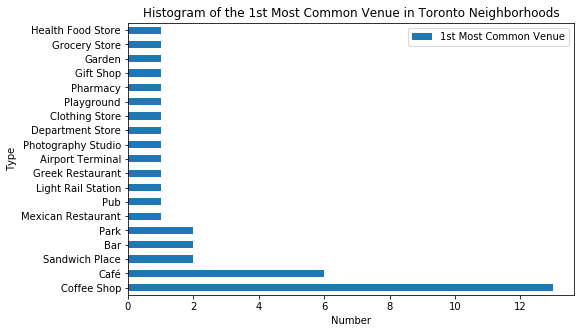

In [18]:
FirstVenue.plot(kind = "barh", figsize = (8,5))
plt.title("Histogram of the 1st Most Common Venue in Toronto Neighborhoods")
plt.xlabel("Number")
plt.ylabel("Type")
plt.show()

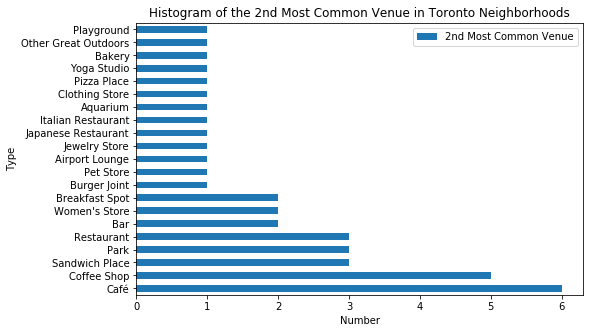

In [19]:
SecondVenue.plot(kind = "barh", figsize = (8,5))
plt.title("Histogram of the 2nd Most Common Venue in Toronto Neighborhoods")
plt.xlabel("Number")
plt.ylabel("Type")
plt.show()

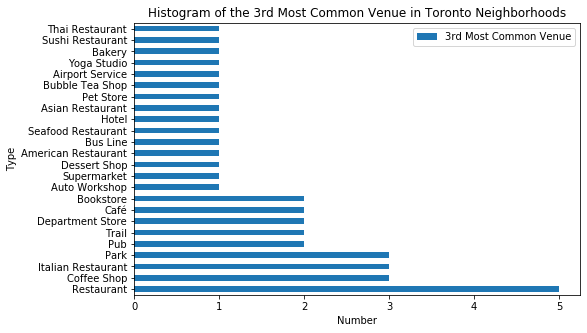

In [20]:
ThirdVenue.plot(kind = "barh", figsize = (8,5))
plt.title("Histogram of the 3rd Most Common Venue in Toronto Neighborhoods")
plt.xlabel("Number")
plt.ylabel("Type")
plt.show()

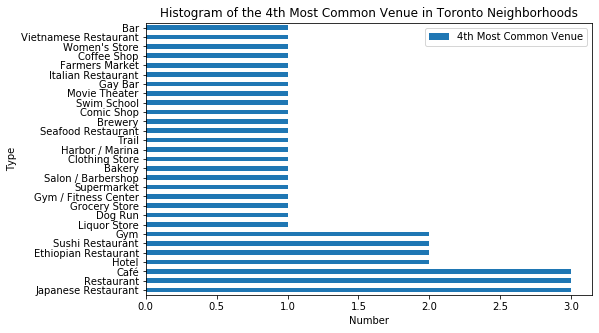

In [21]:
FourthVenue.plot(kind = "barh", figsize = (8,5))
plt.title("Histogram of the 4th Most Common Venue in Toronto Neighborhoods")
plt.xlabel("Number")
plt.ylabel("Type")
plt.show()

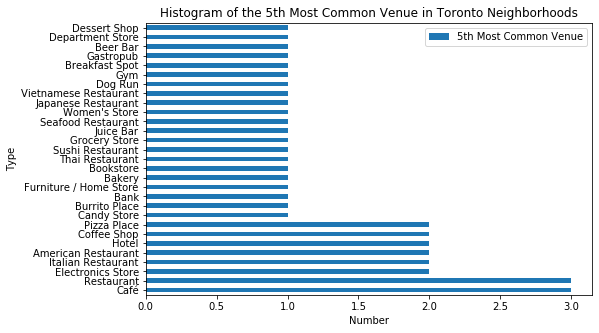

In [22]:
FifthVenue.plot(kind = "barh", figsize = (8,5))
plt.title("Histogram of the 5th Most Common Venue in Toronto Neighborhoods")
plt.xlabel("Number")
plt.ylabel("Type")
plt.show()

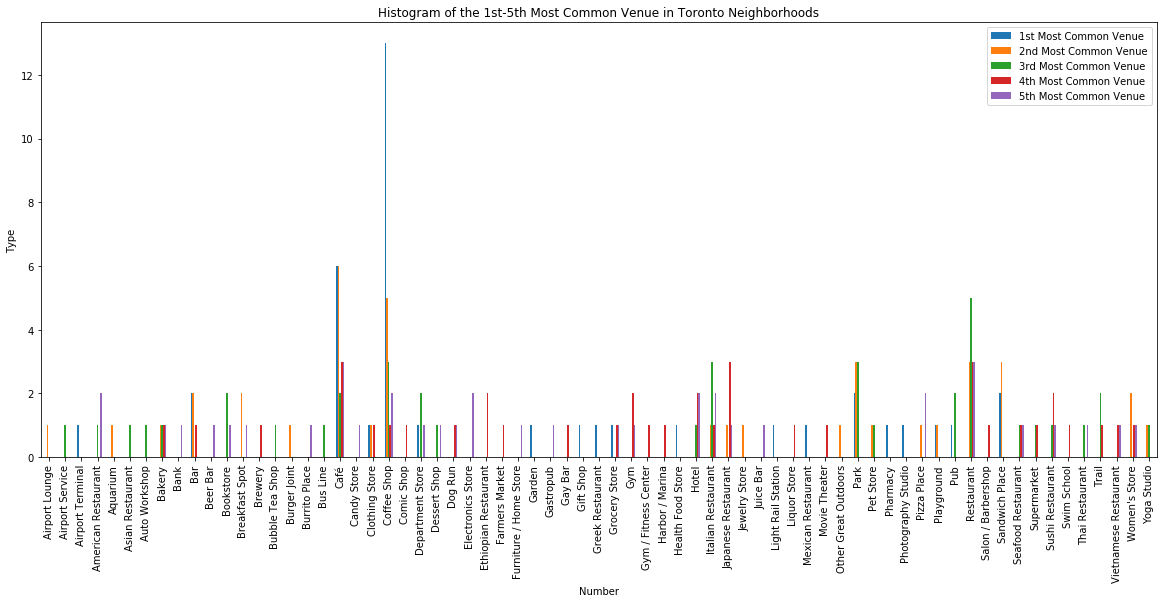

In [23]:
commonvenue = pd.merge(FirstVenue, SecondVenue, how = "outer", on = None, left_index = True, right_index = True)
commonvenue = pd.merge(commonvenue, ThirdVenue, how = "outer", on = None, left_index = True, right_index = True)
commonvenue = pd.merge(commonvenue, FourthVenue, how = "outer", on = None, left_index = True, right_index = True)
commonvenue = pd.merge(commonvenue, FifthVenue, how = "outer", on = None, left_index = True, right_index = True)

commonvenue.plot(kind = "bar", figsize = (20,8))
plt.title("Histogram of the 1st-5th Most Common Venue in Toronto Neighborhoods")
plt.xlabel("Number")
plt.ylabel("Type")
plt.show()

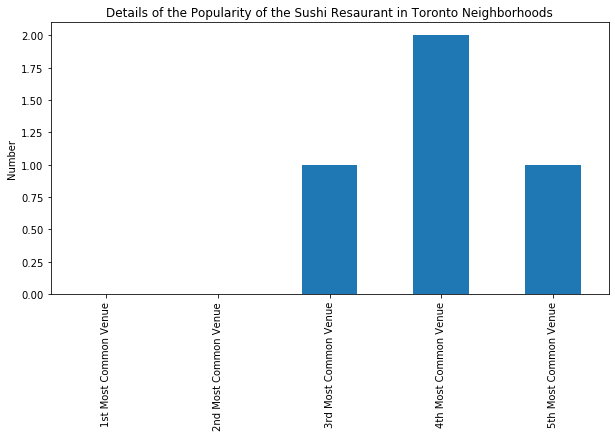

In [24]:
commonvenue.loc["Sushi Restaurant",].plot(kind = "bar", figsize = (10,5))
plt.title("Details of the Popularity of the Sushi Resaurant in Toronto Neighborhoods")
plt.ylabel("Number")
plt.show()

**Step 3: Find the best place for a sushi restaurant**

**Step 3.1: extract the sushi-related restaurants**

In [25]:
sushi = []
for venue in venues:
    venuename = venue["venue"]
    categories = venue["venue"]["categories"]
    name = venue["venue"]["name"]
    location = venue["venue"]["location"]
    pluralname = categories[0]["pluralName"]
    address = location["formattedAddress"]
    lat = location["lat"]
    lng = location["lng"]
    
    if ("sushi" in pluralname.lower()) or ("japan" in pluralname.lower()) \
    or ("asia" in pluralname.lower())  or ("ramen" in pluralname.lower()):
        row = (name, address, lat, lng)
        sushi.append(row)

sushi = pd.DataFrame(sushi, columns=["Name", "Address", "Latitude", "Longitude"])
sushi

,Name,Address,Latitude,Longitude
0,Japango,"[122 Elizabeth St. (at Dundas St. W), Toronto ...",43.655268,-79.385165
1,Manpuku まんぷく,"[105 McCaul St. Unit 29-31 (at Dundas St. W.),...",43.653612,-79.390613
2,Sansotei Ramen 三草亭,[179 Dundas St. W (btwn Centre Ave. & Chestnut...,43.655157,-79.386501
3,Rolltation,"[207 Dundas St W (at University Ave), Toronto ...",43.654918,-79.387424
4,JaBistro,"[222 Richmond St W, Toronto ON M5V 1W4, Canada]",43.649687,-79.388090
5,Noodle King,"[123 Queen St. W. (in Toronto's PATH Walkway),...",43.651706,-79.383046
6,Hakata Ikkousha Ramen,"[249 Queen Street West, Toronto ON M5V 1Z4, Ca...",43.650299,-79.388753
7,Bosk at Shangri-La,"[188 University Ave., Toronto ON M5H 0A3, Canada]",43.649023,-79.385826


**Step 3.2: heatmap of the most common sushi-related restaurants**

In [26]:
address = 'Toronto'
geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

map_trt = folium.Map(location=[latitude, longitude], zoom_start = 15)

add_markers(sushi, map_trt)
heat = sushi[["Latitude", "Longitude"]].as_matrix().tolist()
map_trt.add_child(plugins.HeatMap(heat))

map_trt

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Using Nominatim with the default "geopy/1.21.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.


**Step 3.3: get the result of the potential best location**

In [27]:
ourbest_lat = sushi["Latitude"].mean()
ourbest_lng = sushi["Longitude"].mean()

In [28]:
folium.CircleMarker(
    [ourbest_lat, ourbest_lng],
    radius = 8,
    popup = "Our Best Location",
    color = 'red',
    fill = True,
    fill_color = '#FF0000',
    fill_opacity = 0.7,
    parse_html = False).add_to(map_trt)

map_trt

### Result and Conclusion

From taking the mean of most popular sushi-related restaurants in Toronto, we finally get our result of potential best place for a new sushi restaurant -- On University Avenue to the south of University/Armoury.

### Discussion

The sushi restaurant is among one of the most popular venues in the city of Toronto. With 1 3rd most common, 2 4th most common and 1 5th most common ranks in the neighborhoods of Toronto, we can see that opening a sushi restaurant can be a promising business to start.

Although there can be more factors affecting the choice of location in the real life such as rent, prices and traffic conditions, we are able to obtain the result of a potential best place by assessing the location and popularity of other popular sushi-related restaurants.

Finally, we have our best place - University Avenue to the south of University/Armoury. The address is in the neighborhood where sushi is loved and it also has a fair distance from all the other popular sushi-related restaurants.